# Coin Regression Pipeline
Integrazione con ResNet, MobileNet, Grayscale e Analisi Statistica

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18, mobilenet_v3_small, ResNet18_Weights, MobileNet_V3_Small_Weights
from sklearn.model_selection import KFold
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf


In [2]:
# Paths
CSV_PATH = "dati/Caltavuturo_unionized_cluster_ready_WITH_ID.tsv"
IMAGE_DIR = "/Users/ludovicapresta/Desktop/progetto_revelis/output_monete"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 20
KFOLD_SPLITS = 5
SEED = 42
DATASET = "dati/Caltavuturo_unionized.tsv"
# Model parameters
BACKBONE_NAME = "resnet18"  # "resnet18" or "mobilenet_v3_small"
PRETRAINED_BACKBONE = True
PROJ_DIM = 32            # Projection dimension after backbone features
SHARED_BACKBONE = True   # Whether to share backbone for front/back images
# Grayscale option: True for grayscale (1 channel), False for RGB (3 channels)
USE_GRAYSCALE = True
# DataLoader parameters
NUM_WORKERS = 0



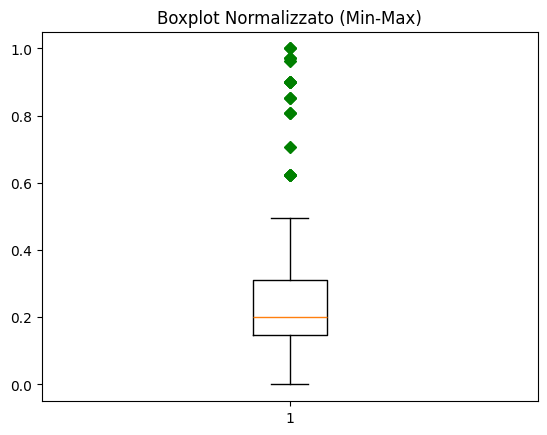

In [ ]:

df_1= pd.read_csv(DATASET,delimiter='\t') 
df = df_1[['N.I.', 'start_year']]






In [ ]:
def get_image_paths(df, image_dir):
    image_pairs = []
    for _, row in df.iterrows():
        coin_id = str(int(row['N.I.']))
      

        year = row['year_real_normalized']
        
        
        front_image_path = os.path.join(image_dir, f"{coin_id}_D.jpg")
        back_image_path = os.path.join(image_dir, f"{coin_id}_R.jpg")

        
        if os.path.exists(front_image_path) and os.path.exists(back_image_path):
            image_pairs.append((front_image_path, back_image_path, year))

       


    
    return image_pairs

In [ ]:
class CoinDataset(Dataset):
    def __init__(self, image_pairs, transform=None):
        self.image_pairs = image_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        front_path, back_path, year = self.image_pairs[idx]
        front_img = Image.open(front_path).convert("RGB")  
        back_img = Image.open(back_path).convert("RGB")

        if self.transform:
            front_img = self.transform(front_img)
            back_img = self.transform(back_img)

        return front_img, back_img, torch.tensor(float(year), dtype=torch.float32)


In [6]:
def get_backbone(name: str, pretrained=True, grayscale=False):
    if name == "resnet18":
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        model = resnet18(weights=weights)
        if grayscale:
            original_conv = model.conv1
            new_conv = nn.Conv2d(1,
                                 original_conv.out_channels,
                                 kernel_size=original_conv.kernel_size,
                                 stride=original_conv.stride,
                                 padding=original_conv.padding,
                                 bias=original_conv.bias is not None)
            with torch.no_grad():
                new_conv.weight[:] = original_conv.weight.mean(dim=1, keepdim=True)
            model.conv1 = new_conv

        feature_extractor = nn.Sequential(*list(model.children())[:-1])
        feature_dim = 512

    elif name == "mobilenet_v3_small":
        weights = MobileNet_V3_Small_Weights.DEFAULT if pretrained else None
        model = mobilenet_v3_small(weights=weights)
        if grayscale:
            original_conv = model.features[0][0]
            new_conv = nn.Conv2d(1,
                                 original_conv.out_channels,
                                 kernel_size=original_conv.kernel_size,
                                 stride=original_conv.stride,
                                 padding=original_conv.padding,
                                 bias=original_conv.bias is not None)
            with torch.no_grad():
                new_conv.weight[:] = original_conv.weight.mean(dim=1, keepdim=True)
            model.features[0][0] = new_conv

        feature_extractor = model.features
        feature_dim = 576

    else:
        raise ValueError(f"Unsupported model name: {name}")

    return feature_extractor, feature_dim



In [7]:
class DualImageRegressor(nn.Module):
    def __init__(self, backbone_name=BACKBONE_NAME, pretrained=PRETRAINED_BACKBONE,
                 proj_dim=PROJ_DIM, shared_backbone=SHARED_BACKBONE, grayscale=USE_GRAYSCALE):
        super().__init__()

        self.shared_backbone = shared_backbone

        if shared_backbone:
            self.cnn, feature_dim = get_backbone(backbone_name, pretrained, grayscale)
        else:
            self.front_cnn, feature_dim = get_backbone(backbone_name, pretrained, grayscale)
            self.back_cnn, _ = get_backbone(backbone_name, pretrained, grayscale)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.front_proj = nn.Linear(feature_dim, proj_dim)
        self.back_proj = nn.Linear(feature_dim, proj_dim)

        self.regressor = nn.Sequential(
            nn.Linear(proj_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, front_img, back_img):
        if self.shared_backbone:
            front_feat = self.global_pool(self.cnn(front_img)).view(front_img.size(0), -1)
            back_feat = self.global_pool(self.cnn(back_img)).view(back_img.size(0), -1)
        else:
            front_feat = self.global_pool(self.front_cnn(front_img)).view(front_img.size(0), -1)
            back_feat = self.global_pool(self.back_cnn(back_img)).view(back_img.size(0), -1)

        front_proj = self.front_proj(front_feat)
        back_proj = self.back_proj(back_feat)

        combined = torch.cat((front_proj, back_proj), dim=1)
        return self.regressor(combined)

In [ ]:
def train_model(fold, model, train_loader, val_loader, epochs=EPOCHS, device=DEVICE):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  


    history = {
        'train_loss': [],
        'val_loss': []
    }

    
   

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for front, back, year in train_loader:
            front, back, year = front.to(device), back.to(device), year.to(device)
            
            outputs = model(front, back).squeeze()
            loss = criterion(outputs, year)
            loss.backward()
     
            train_loss += loss.item()

        # Validazione
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for front, back, year in val_loader:
                front, back, year = front.to(device), back.to(device), year.to(device)
                outputs = model(front, back).squeeze()
                loss = criterion(outputs, year)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

      




    # 📊 Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(history['train_loss'], label='Train Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.set_title('Andamento della Loss')
    ax.set_xlabel('Epoca')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model


In [ ]:
def evaluate_model(model, dataloader, min_year, max_year, device=DEVICE):
    model.eval()
    model.to(device)
    
    all_preds, all_targets = [], []

    with torch.no_grad():
        for front, back, year in dataloader:
            front, back, year = front.to(device), back.to(device), year.to(device)
            outputs = model(front, back).view(-1)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(year.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

   
    all_preds = all_preds * (max_year - min_year) + min_year
    all_targets = all_targets * (max_year - min_year) + min_year

    mae = np.mean(np.abs(all_preds - all_targets))
    rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))

    acc_5 = np.mean(np.abs(all_preds - all_targets) <= 5)
    acc_10 = np.mean(np.abs(all_preds - all_targets) <= 10)
    acc_50 = np.mean(np.abs(all_preds - all_targets) <= 50)

    
    def year_to_decade_bin(year_real):
        return int(year_real // 10) * 10

    pred_decades = [year_to_decade_bin(y) for y in all_preds]
    true_decades = [year_to_decade_bin(y) for y in all_targets]




    print(f"\nMAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Accuracy ±5 anni: {acc_5 * 100:.2f}%")
    print(f"Accuracy ±10 anni: {acc_10 * 100:.2f}%")
    print(f"Accuracy ±50 anni: {acc_50 * 100:.2f}%")

    return mae, rmse, acc_5, acc_10, acc_50, true_decades, pred_decades


In [11]:
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Totale immagini: 278 | Train: 250 | Test: 28

--- Fold 1 ---
 -> Train fold size: 200 | Val fold size: 50
Epoch 1: Train Loss = 0.0616 | Val Loss = 0.0900
✔️  Validation loss improved. Model saved at epoch 1
Epoch 2: Train Loss = 0.0308 | Val Loss = 0.0089
✔️  Validation loss improved. Model saved at epoch 2
Epoch 3: Train Loss = 0.0210 | Val Loss = 0.0243
Epoch 4: Train Loss = 0.0209 | Val Loss = 0.0211
Epoch 5: Train Loss = 0.0152 | Val Loss = 0.0089
Epoch 6: Train Loss = 0.0125 | Val Loss = 0.0173
Epoch 7: Train Loss = 0.0062 | Val Loss = 0.0029
⛔ Early stopping at epoch 7
✅ Best model reloaded.


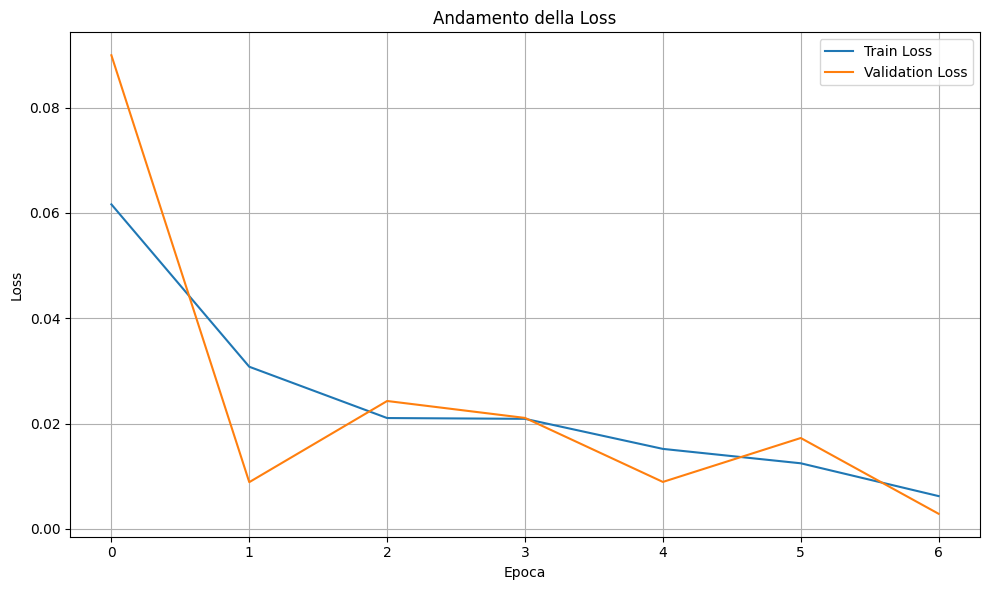


--- Predizioni dettagliate ---
Sample 1: True=125.0, Predicted=134.5, Δ=9.5 anni
Sample 2: True=136.0, Predicted=151.7, Δ=15.7 anni
Sample 3: True=119.0, Predicted=128.8, Δ=9.8 anni
Sample 4: True=122.0, Predicted=132.4, Δ=10.4 anni
Sample 5: True=118.0, Predicted=121.4, Δ=3.4 anni
Sample 6: True=111.0, Predicted=130.0, Δ=19.0 anni
Sample 7: True=124.0, Predicted=150.8, Δ=26.8 anni
Sample 8: True=148.0, Predicted=160.9, Δ=12.9 anni
Sample 9: True=119.0, Predicted=132.4, Δ=13.4 anni
Sample 10: True=121.0, Predicted=138.0, Δ=17.0 anni
Sample 11: True=134.0, Predicted=124.8, Δ=9.2 anni
Sample 12: True=115.0, Predicted=138.9, Δ=23.9 anni
Sample 13: True=124.0, Predicted=119.6, Δ=4.4 anni
Sample 14: True=115.0, Predicted=121.7, Δ=6.7 anni
Sample 15: True=122.0, Predicted=138.9, Δ=16.9 anni
Sample 16: True=118.0, Predicted=127.5, Δ=9.5 anni
Sample 17: True=115.0, Predicted=144.5, Δ=29.5 anni
Sample 18: True=112.0, Predicted=125.2, Δ=13.2 anni
Sample 19: True=119.0, Predicted=128.3, Δ=9.3 an

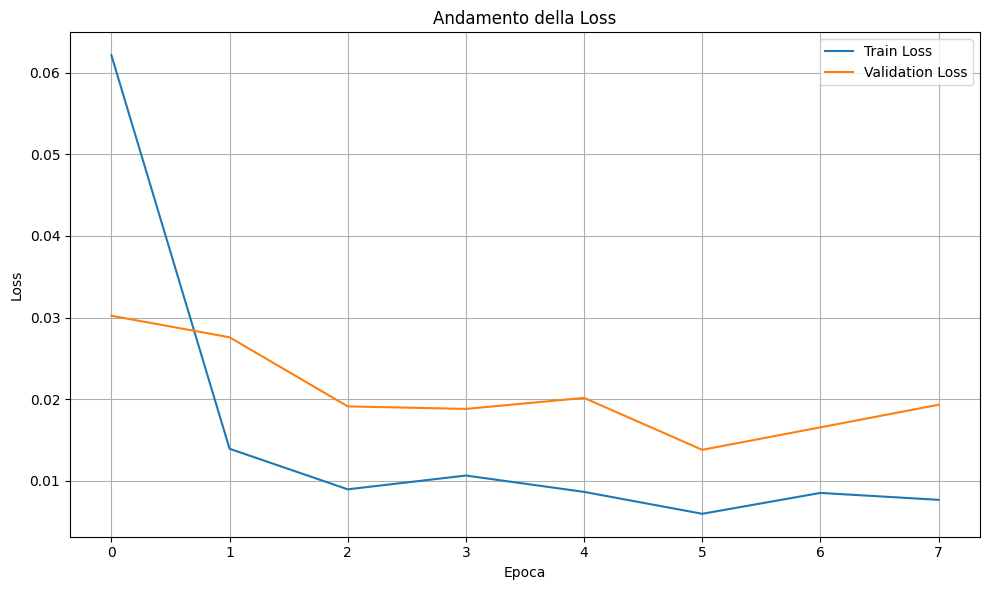


--- Predizioni dettagliate ---
Sample 1: True=111.0, Predicted=118.3, Δ=7.3 anni
Sample 2: True=115.0, Predicted=138.2, Δ=23.2 anni
Sample 3: True=124.0, Predicted=131.2, Δ=7.2 anni
Sample 4: True=138.0, Predicted=155.3, Δ=17.3 anni
Sample 5: True=118.0, Predicted=128.6, Δ=10.6 anni
Sample 6: True=124.0, Predicted=132.7, Δ=8.7 anni
Sample 7: True=114.0, Predicted=117.4, Δ=3.4 anni
Sample 8: True=118.0, Predicted=118.7, Δ=0.7 anni
Sample 9: True=127.0, Predicted=130.9, Δ=3.9 anni
Sample 10: True=124.0, Predicted=123.2, Δ=0.8 anni
Sample 11: True=130.0, Predicted=131.4, Δ=1.4 anni
Sample 12: True=112.0, Predicted=137.6, Δ=25.6 anni
Sample 13: True=134.0, Predicted=133.4, Δ=0.6 anni
Sample 14: True=124.0, Predicted=128.1, Δ=4.1 anni
Sample 15: True=136.0, Predicted=124.0, Δ=12.0 anni
Sample 16: True=118.0, Predicted=120.0, Δ=2.0 anni
Sample 17: True=123.0, Predicted=134.4, Δ=11.4 anni
Sample 18: True=170.0, Predicted=130.7, Δ=39.3 anni
Sample 19: True=120.0, Predicted=128.8, Δ=8.8 anni
S

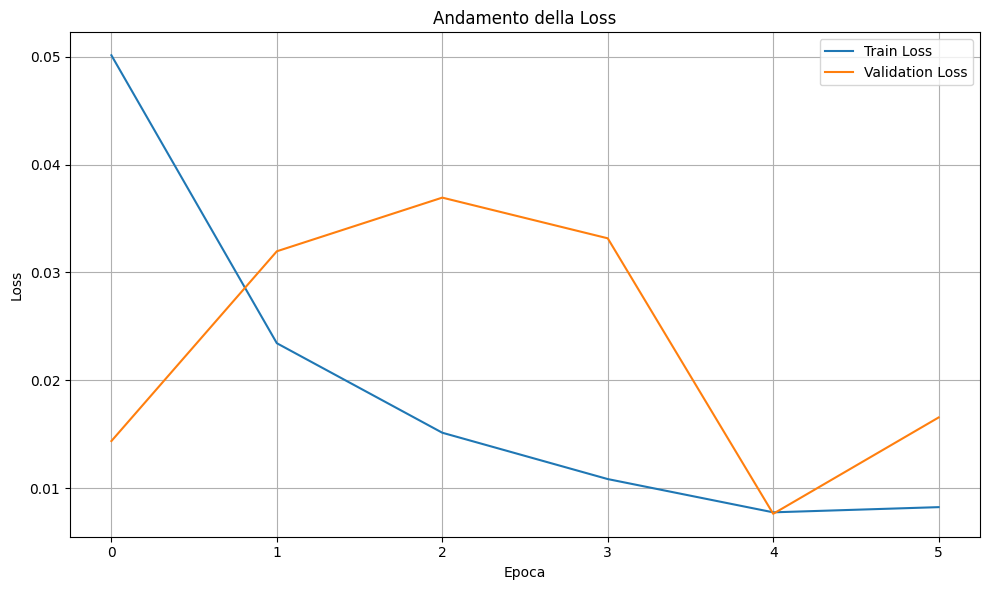


--- Predizioni dettagliate ---
Sample 1: True=119.0, Predicted=124.6, Δ=5.6 anni
Sample 2: True=122.0, Predicted=114.4, Δ=7.6 anni
Sample 3: True=122.0, Predicted=104.4, Δ=17.6 anni
Sample 4: True=133.0, Predicted=113.5, Δ=19.5 anni
Sample 5: True=136.0, Predicted=103.4, Δ=32.6 anni
Sample 6: True=119.0, Predicted=112.3, Δ=6.7 anni
Sample 7: True=141.0, Predicted=136.6, Δ=4.4 anni
Sample 8: True=119.0, Predicted=117.0, Δ=2.0 anni
Sample 9: True=136.0, Predicted=104.1, Δ=31.9 anni
Sample 10: True=119.0, Predicted=110.0, Δ=9.0 anni
Sample 11: True=124.0, Predicted=118.9, Δ=5.1 anni
Sample 12: True=131.0, Predicted=126.7, Δ=4.3 anni
Sample 13: True=137.0, Predicted=120.1, Δ=16.9 anni
Sample 14: True=123.0, Predicted=121.2, Δ=1.8 anni
Sample 15: True=112.0, Predicted=107.6, Δ=4.4 anni
Sample 16: True=119.0, Predicted=97.5, Δ=21.5 anni
Sample 17: True=124.0, Predicted=116.1, Δ=7.9 anni
Sample 18: True=127.0, Predicted=122.2, Δ=4.8 anni
Sample 19: True=121.0, Predicted=117.2, Δ=3.8 anni
Sam

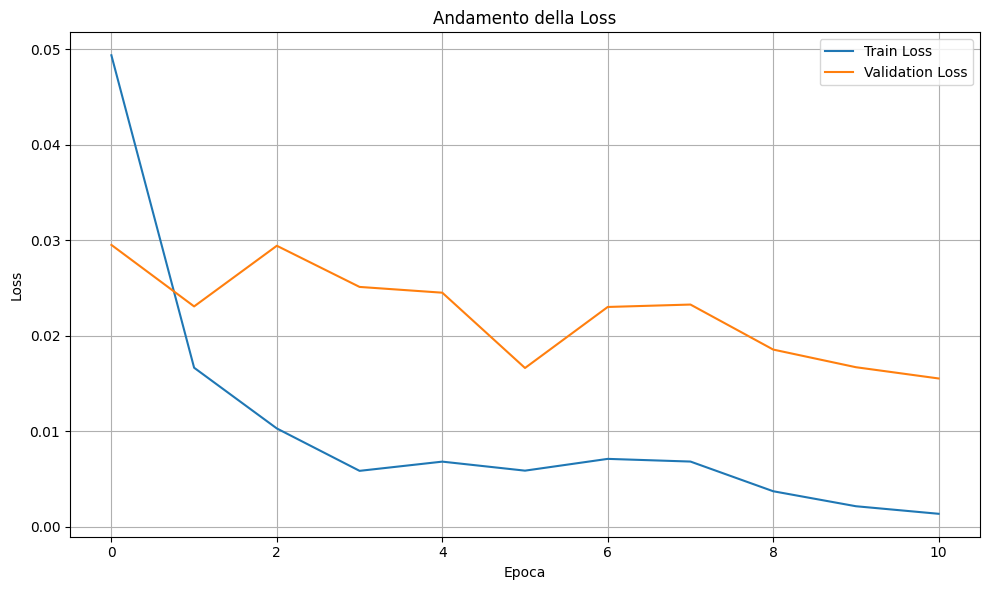


--- Predizioni dettagliate ---
Sample 1: True=136.0, Predicted=122.1, Δ=13.9 anni
Sample 2: True=124.0, Predicted=122.6, Δ=1.4 anni
Sample 3: True=136.0, Predicted=140.0, Δ=4.0 anni
Sample 4: True=137.0, Predicted=128.6, Δ=8.4 anni
Sample 5: True=132.0, Predicted=123.9, Δ=8.1 anni
Sample 6: True=137.0, Predicted=125.0, Δ=12.0 anni
Sample 7: True=127.0, Predicted=127.3, Δ=0.3 anni
Sample 8: True=133.0, Predicted=122.1, Δ=10.9 anni
Sample 9: True=113.0, Predicted=116.3, Δ=3.3 anni
Sample 10: True=114.0, Predicted=116.7, Δ=2.7 anni
Sample 11: True=148.0, Predicted=121.0, Δ=27.0 anni
Sample 12: True=132.0, Predicted=120.3, Δ=11.7 anni
Sample 13: True=124.0, Predicted=120.3, Δ=3.7 anni
Sample 14: True=115.0, Predicted=115.8, Δ=0.8 anni
Sample 15: True=120.0, Predicted=127.5, Δ=7.5 anni
Sample 16: True=148.0, Predicted=147.6, Δ=0.4 anni
Sample 17: True=137.0, Predicted=140.4, Δ=3.4 anni
Sample 18: True=107.0, Predicted=118.3, Δ=11.3 anni
Sample 19: True=127.0, Predicted=121.7, Δ=5.3 anni
Sa

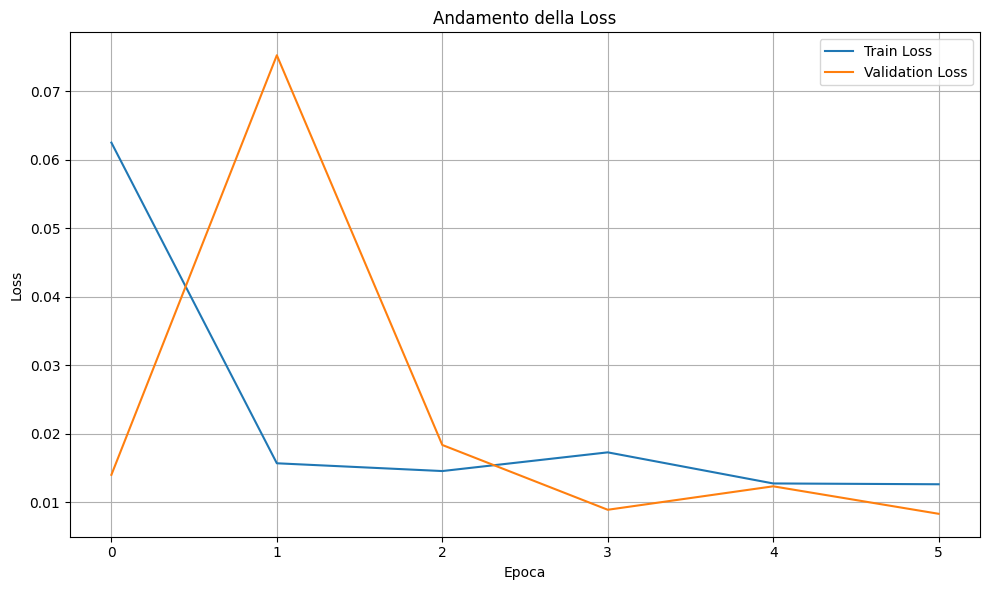


--- Predizioni dettagliate ---
Sample 1: True=118.0, Predicted=116.6, Δ=1.4 anni
Sample 2: True=120.0, Predicted=128.3, Δ=8.3 anni
Sample 3: True=137.0, Predicted=145.0, Δ=8.0 anni
Sample 4: True=121.0, Predicted=104.5, Δ=16.5 anni
Sample 5: True=132.0, Predicted=120.3, Δ=11.7 anni
Sample 6: True=135.0, Predicted=139.9, Δ=4.9 anni
Sample 7: True=118.0, Predicted=119.6, Δ=1.6 anni
Sample 8: True=137.0, Predicted=124.3, Δ=12.7 anni
Sample 9: True=154.0, Predicted=126.0, Δ=28.0 anni
Sample 10: True=112.0, Predicted=116.2, Δ=4.2 anni
Sample 11: True=127.0, Predicted=128.9, Δ=1.9 anni
Sample 12: True=121.0, Predicted=120.5, Δ=0.5 anni
Sample 13: True=112.0, Predicted=124.6, Δ=12.6 anni
Sample 14: True=122.0, Predicted=129.9, Δ=7.9 anni
Sample 15: True=117.0, Predicted=124.0, Δ=7.0 anni
Sample 16: True=124.0, Predicted=114.8, Δ=9.2 anni
Sample 17: True=130.0, Predicted=128.7, Δ=1.3 anni
Sample 18: True=136.0, Predicted=117.7, Δ=18.3 anni
Sample 19: True=139.0, Predicted=137.1, Δ=1.9 anni
Sa

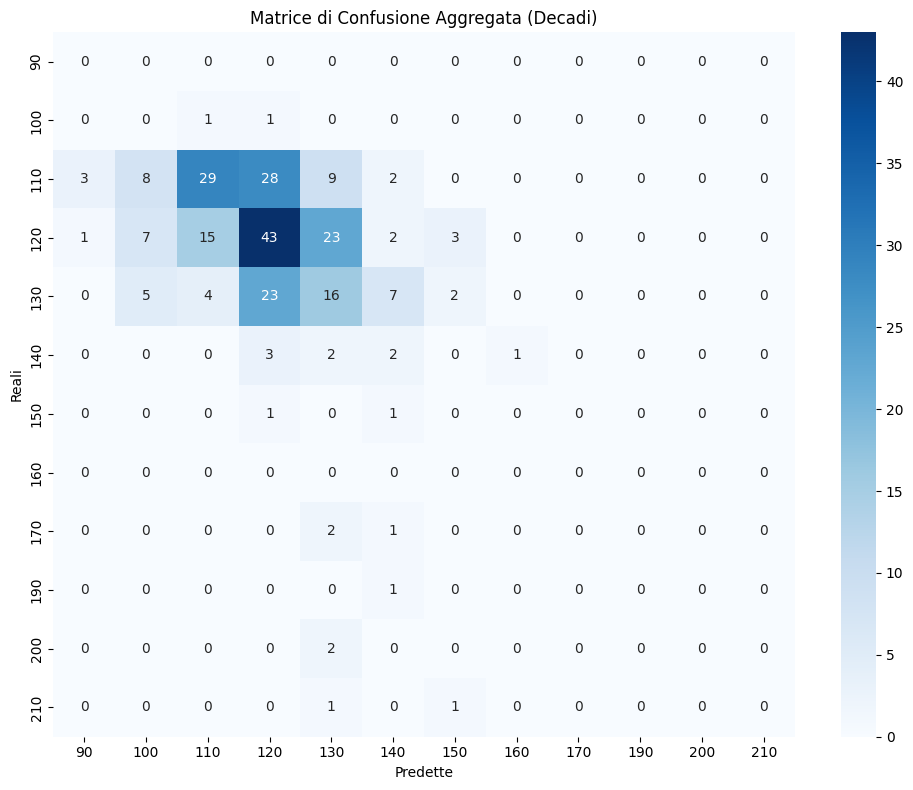


📉 Matrice di confusione aggregata:
[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  0  0]
 [ 3  8 29 28  9  2  0  0  0  0  0  0]
 [ 1  7 15 43 23  2  3  0  0  0  0  0]
 [ 0  5  4 23 16  7  2  0  0  0  0  0]
 [ 0  0  0  3  2  2  0  1  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0  0  0]]

📈 Report di classificazione aggregato:
              precision    recall  f1-score   support

          90       0.00      0.00      0.00         0
         100       0.00      0.00      0.00         2
         110       0.59      0.37      0.45        79
         120       0.43      0.46      0.45        94
         130       0.29      0.28      0.29        57
         140       0.12      0.25      0.17         8
         150       0.00      0.00      0.00         2
         160       0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [ ]:
if __name__ == "__main__":
    set_seed()

    image_pairs = get_image_paths(df, IMAGE_DIR)

    train_pairs, test_pairs = train_test_split(image_pairs, test_size=0.1, random_state=SEED)
    print(f"Totale immagini: {len(image_pairs)} | Train: {len(train_pairs)} | Test: {len(test_pairs)}")

    # Transform pipeline (usa solo grayscale come richiesto)
    transform_pipeline = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])

  
    train_dataset = CoinDataset(train_pairs, transform=transform_pipeline)
    test_dataset = CoinDataset(test_pairs, transform=transform_pipeline)


    mae_list, rmse_list, accuracy_5_list, accuracy_10_list, accuracy_50_list = [], [], [], [], []
    all_true_decades, all_pred_decades = [], []
    modelli_addestrati = []

  
    min_year = df['year_real'].min()
    max_year = df['year_real'].max()

    kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f"\n--- Fold {fold + 1} ---")
        print(f" -> Train fold size: {len(train_idx)} | Val fold size: {len(val_idx)}")

        model = DualImageRegressor()
        train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(Subset(train_dataset, val_idx), batch_size=BATCH_SIZE)

        trained = train_model(fold, model, train_loader, val_loader, device=DEVICE)

        mae, rmse, acc5, acc10, acc50, true_decades, pred_decades = evaluate_model(
            model, val_loader, min_year=min_year, max_year=max_year, device=DEVICE
        )

        mae_list.append(mae)
        rmse_list.append(rmse)
        accuracy_5_list.append(acc5)
        accuracy_10_list.append(acc10)
        accuracy_50_list.append(acc50)
        all_true_decades.extend(true_decades)
        all_pred_decades.extend(pred_decades)
        modelli_addestrati.append(trained)

    
   

    
    print("\n📉 Matrice di confusione aggregata (visuale):")
    cm = confusion_matrix(all_true_decades, all_pred_decades)
    labels = sorted(list(set(all_true_decades + all_pred_decades)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Matrice di Confusione Aggregata (Decadi)")
    plt.xlabel("Predette")
    plt.ylabel("Reali")
    plt.tight_layout()
    plt.show()

   


In [ ]:
def evaluate_models_on_test(models, test_dataset, min_year, max_year, batch_size=32, device='cpu'):
    from torch.utils.data import DataLoader
    import pandas as pd

    results = []
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    for i, model in enumerate(models):
        
        model.to(device)
        model.eval()

        mae, rmse, acc5, acc10, acc50, true_decades, pred_decades = evaluate_model(
            model, test_loader, min_year=min_year, max_year=max_year, device=device
        )

        results.append({
            'Modello': f'Model_{i+1}',
            'MAE': mae,
            'RMSE': rmse,
            'Accuracy ±5 anni': acc5,
            'Accuracy ±10 anni': acc10,
            'Accuracy ±50 anni': acc50
        })

      
      


    df_results = pd.DataFrame(results)

    aggregate = {
        'Modello': 'Media',
        'MAE': df_results['MAE'].mean(),
        'RMSE': df_results['RMSE'].mean(),
        'Accuracy ±5 anni': df_results['Accuracy ±5 anni'].mean(),
        'Accuracy ±10 anni': df_results['Accuracy ±10 anni'].mean(),
        'Accuracy ±50 anni': df_results['Accuracy ±50 anni'].mean()
    }
    df_results = pd.concat([df_results, pd.DataFrame([aggregate])], ignore_index=True)

    return df_results


In [ ]:
min_year = df['year_real'].min()
max_year = df['year_real'].max()

df_test_results = evaluate_models_on_test(
    modelli_addestrati,
    test_dataset,
    min_year=min_year,
    max_year=max_year,
    device=DEVICE
)




--- Predizioni dettagliate ---
Sample 1: True=121.0, Predicted=129.1, Δ=8.1 anni
Sample 2: True=118.0, Predicted=136.3, Δ=18.3 anni
Sample 3: True=138.0, Predicted=131.1, Δ=6.9 anni
Sample 4: True=125.0, Predicted=139.3, Δ=14.3 anni
Sample 5: True=145.0, Predicted=145.6, Δ=0.6 anni
Sample 6: True=136.0, Predicted=140.2, Δ=4.2 anni
Sample 7: True=124.0, Predicted=125.1, Δ=1.1 anni
Sample 8: True=115.0, Predicted=117.3, Δ=2.3 anni
Sample 9: True=141.0, Predicted=140.3, Δ=0.7 anni
Sample 10: True=107.0, Predicted=125.9, Δ=18.9 anni
Sample 11: True=124.0, Predicted=125.9, Δ=1.9 anni
Sample 12: True=115.0, Predicted=122.0, Δ=7.0 anni
Sample 13: True=126.0, Predicted=163.0, Δ=37.0 anni
Sample 14: True=124.0, Predicted=122.0, Δ=2.0 anni
Sample 15: True=132.0, Predicted=153.0, Δ=21.0 anni
Sample 16: True=118.0, Predicted=119.7, Δ=1.7 anni
Sample 17: True=132.0, Predicted=148.6, Δ=16.6 anni
Sample 18: True=120.0, Predicted=127.1, Δ=7.1 anni
Sample 19: True=130.0, Predicted=136.9, Δ=6.9 anni
Sa